# Data Types 

In this notebook, we present the different data types that are currently available in MIIT. MIIT comes with a variety of different imaging data types.

## Set root directory 

Set root directory to the test data

In [1]:
ROOT_DIR = 'test_data/'

# if you follow the docker instructions use this:
# ROOT_DIR = '/external_directory/'

In [2]:
import os
from os.path import exists, join

import cv2
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from miit.spatial_data.section import Section, register_to_ref_image
from miit.spatial_data.base_types import Image, Annotation, Pointset, OMEImage, GeoJSONData
from miit.spatial_data.spatial_omics.imzml import Imzml
from miit.spatial_data.spatial_omics.visium import Visium
from miit.utils.qupath import geojson_to_annotation
import pyimzml

In [3]:
if not exists('output_directory'):
    os.mkdir('output_directory')

## Base types

Base types describe spatial data types that are in a sense atomic, i.e. that do not encapsulate other MIIT data types.

These base types are at the moment: `Image`, `Annotation`, `Pointset`, `GeoJSONData`, `OMETIFFImage`, `OMETIFFAnnotation`

We will go through these data types in the following.

We start by loading all images, annotations and st data separetely. Images can be loaded with any arbitrary library (e.g. OpenCV, SKimage, SimpleITK). 

### Image

`Images` describe standard image data either with in 2D (e.g. for grayscale) or with an additional RGB channel. By default, `images` use LINEAR interpolation for warping after registration.

As for most other MIIT data types, there are two ways of constructing images: Either manually by reading the image or using the classmethod `Image.load_from_path`. If `load_from_path` is used, SimpleITK is used to read images.

Internally, `images` are stored as numpy array.

All MIIT basetypes support a variety of image transformations (such as cropping, resizing, rescaling, padding and flipping amongst others). Note, at the moment all image transformation methods (with the expection of `apply_transformation`) are inplace.

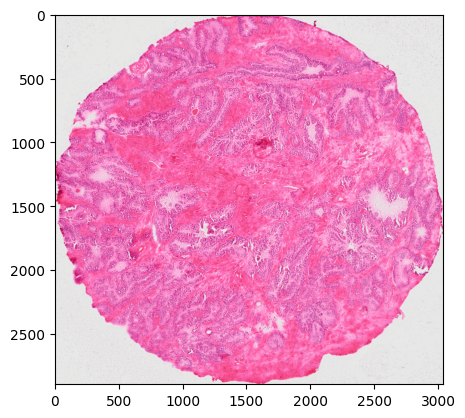

In [4]:
# Option1:
# Load the image first as an numpy array.
reference_image_np = cv2.imread(join(ROOT_DIR, 'test_data/source_data/7/images/image.tif'))
reference_image_np = cv2.cvtColor(reference_image_np, cv2.COLOR_BGR2RGB)


# ...and then put it inside an DefaultImage object. Optionally, a name can be supplied which can make it easier to handle a large amount of sections.
reference_image = Image(data=reference_image_np)

# Option2: 
# ... or alternatively, read_directly from path
reference_image = Image.load_from_path(join(ROOT_DIR, 'test_data/source_data/7/images/image.tif'))

# Internally image data is stored as numpy arrays and can be accessed using the `data` attribute. We can use that for plotting, for instance.
plt.imshow(reference_image.data)

### Annotations

The `Annotation` class is very similar to the `Image` class with the difference that while `Image` should be used for standard image data, `Annotation` is more equipped to dealing with multiple annotations from the same image region and supports labeling. For image transformation, Nearest Neighbor interpolation is used.

As with `Image`, `Annotation` stores internal data as numpy arrays and expects the last channel to be the channel index. If the `Annotation` object is constructed manually, the user needs to ensure the correct orientation. If the `Annotation` object is constructed using `Annotation.load_from_path` the channel index can be specified and data will be rearranged automatically.

Labels can be provided as a newline separated list. If no labels are provided, `Annotation` objects will derive some labeling automatically. But this can be ignored if not needed.

Lastly, `Annotation` objects have 2 modes: multichannel and (implicitly) singlechannel. By default, every `Annotation` is in singlechannel mode, i.e. each annotation is stored in a separate channel. This has advantages, such as allowing pixels to have multiple classifications. However, for large images, this can use up a lot of memory which is why the multichannel mode exists: Instead of having a separate channel for each label, only one channel exists with each label getting a unique identifier. This saves memory, but has the tradeoff that each pixel can only have one class, therefore potentially causing loss of information for overlapping annotations.

In [5]:
# We do this for all the other data types.
# Annotations are placed in Annotation objects.
# tissue_mask_np = sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section1/tissue_mask.tif'))
tissue_mask_np = sitk.GetArrayFromImage(sitk.ReadImage(join(ROOT_DIR, 'test_data/source_data/7/masks/tissue_mask.tif')))
tissue_mask = Annotation(data=tissue_mask_np, name='tissue_mask')

# ... or alternatively:
tissue_mask = Annotation.load_from_path(join(ROOT_DIR, 'test_data/source_data/7/masks/tissue_mask.tif'), name='tissue_mask')

# Optionally, labels can also be loaded and included in Annotations.
hist_annotations = Annotation.load_from_path(join(ROOT_DIR, 'test_data/source_data/7/annotations/annotations.nii.gz'),
                                              path_to_labels=join(ROOT_DIR, 'test_data/source_data/7/annotations/labels.txt'),
                                              channel_idx=0,
                                              name='hist_annotations')

# We can do this also by hand, if necessary
# histopathology_annotations_np = sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section1/labels.nii.gz'))
histopathology_annotations_np = sitk.GetArrayFromImage(sitk.ReadImage(join(ROOT_DIR, 'test_data/source_data/7/annotations/annotations.nii.gz')))
histopathology_annotations_np = np.moveaxis(histopathology_annotations_np, 0, 2)
with open(join(ROOT_DIR, 'test_data/source_data/7/annotations/labels.txt')) as f:
    histopathology_labels = [x.strip() for x in f.readlines()]

hist_annotations2 = Annotation(data=histopathology_annotations_np, labels=histopathology_labels, name='hist_annotations')


# histo_annotations and histo_annotations2 contain the same data
assert np.all(hist_annotations.data == hist_annotations2.data)

We also have a utility method for plotting all annotations. (Dont worry about the empty annotations. Thats expected for this data.) Optionally, we can pass the histology image for a more convenient way of looking at the data.

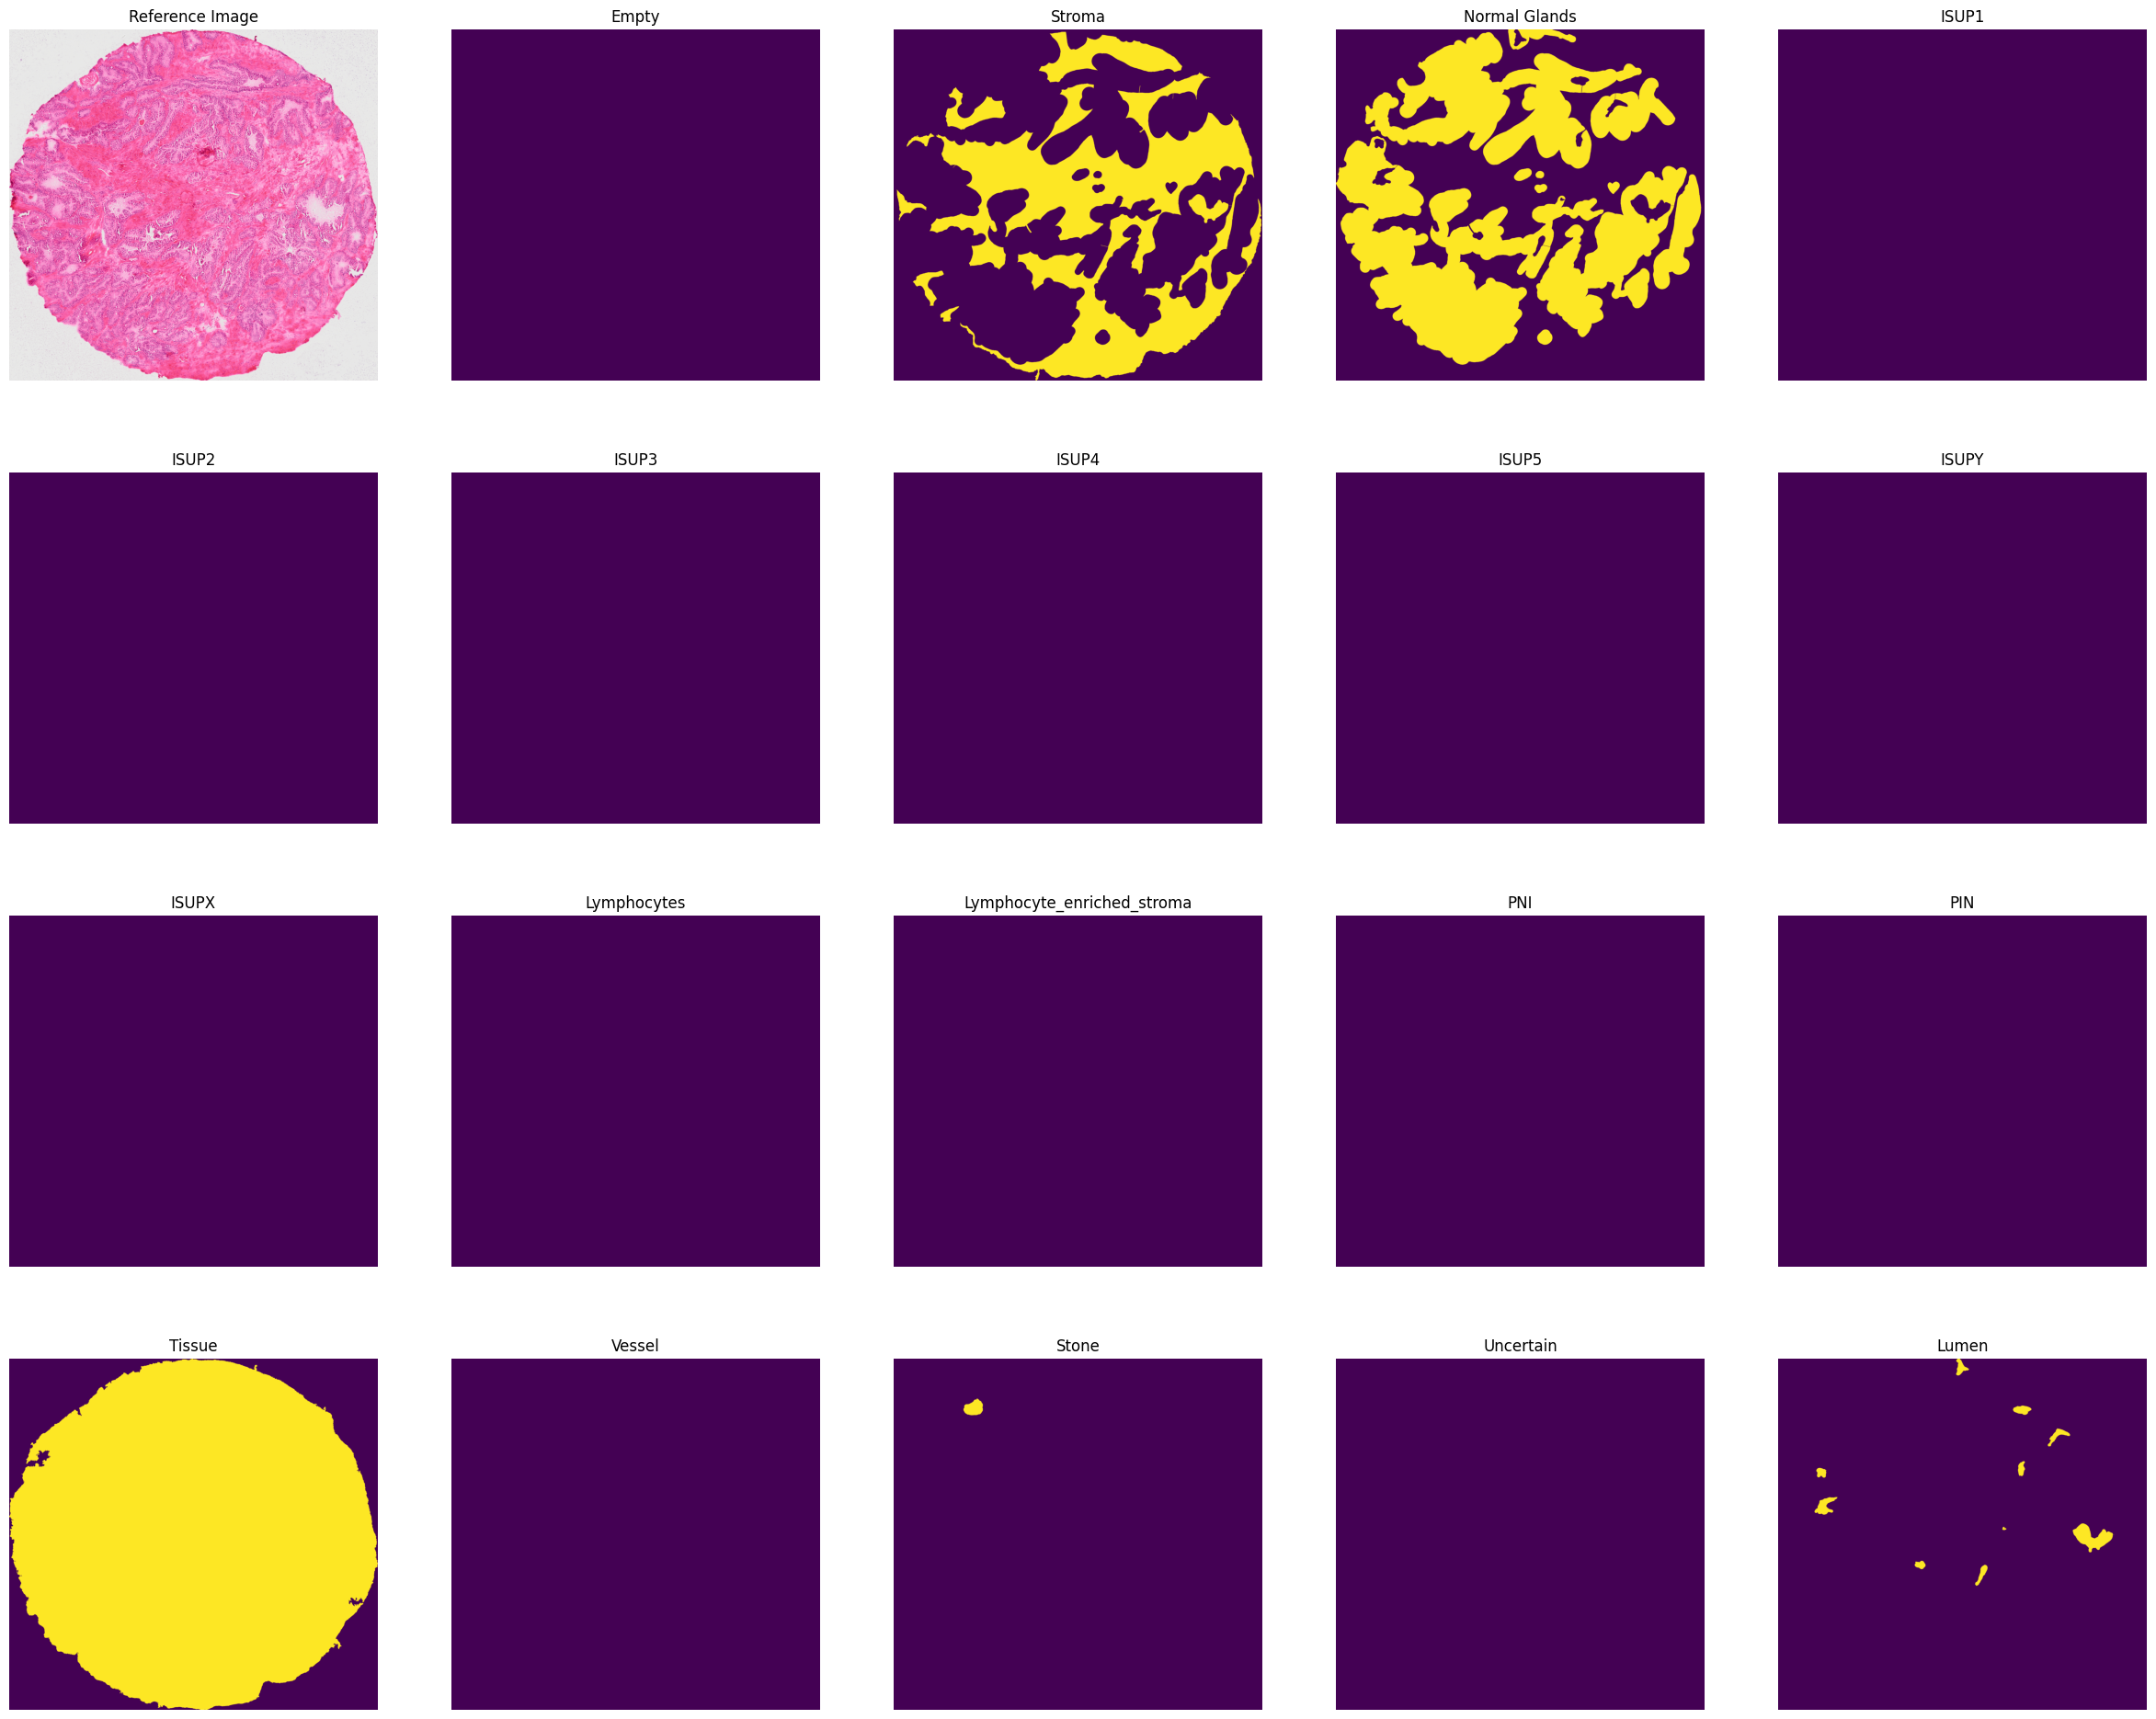

In [6]:
hist_annotations2.plot_annotation(reference_image=reference_image.data)

And we can also get annotations from an `Annotation` for a specific label:

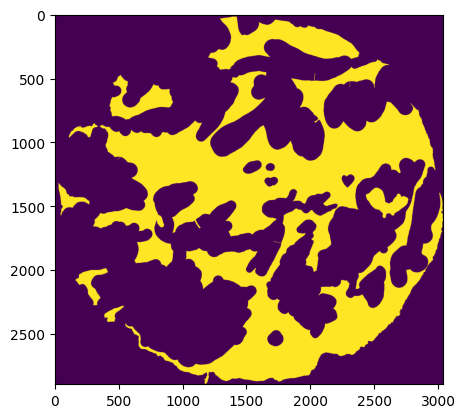

In [7]:
stroma_ann = hist_annotations2.get_by_labels('Stroma')
plt.imshow(stroma_ann)

Finally, we can convert between the different channel modes.

In [8]:
# 1. From singlechannel to multichannel
hist_annotations2.convert_to_multichannel()

assert hist_annotations2.is_multichannel

We can plot all annotations again.

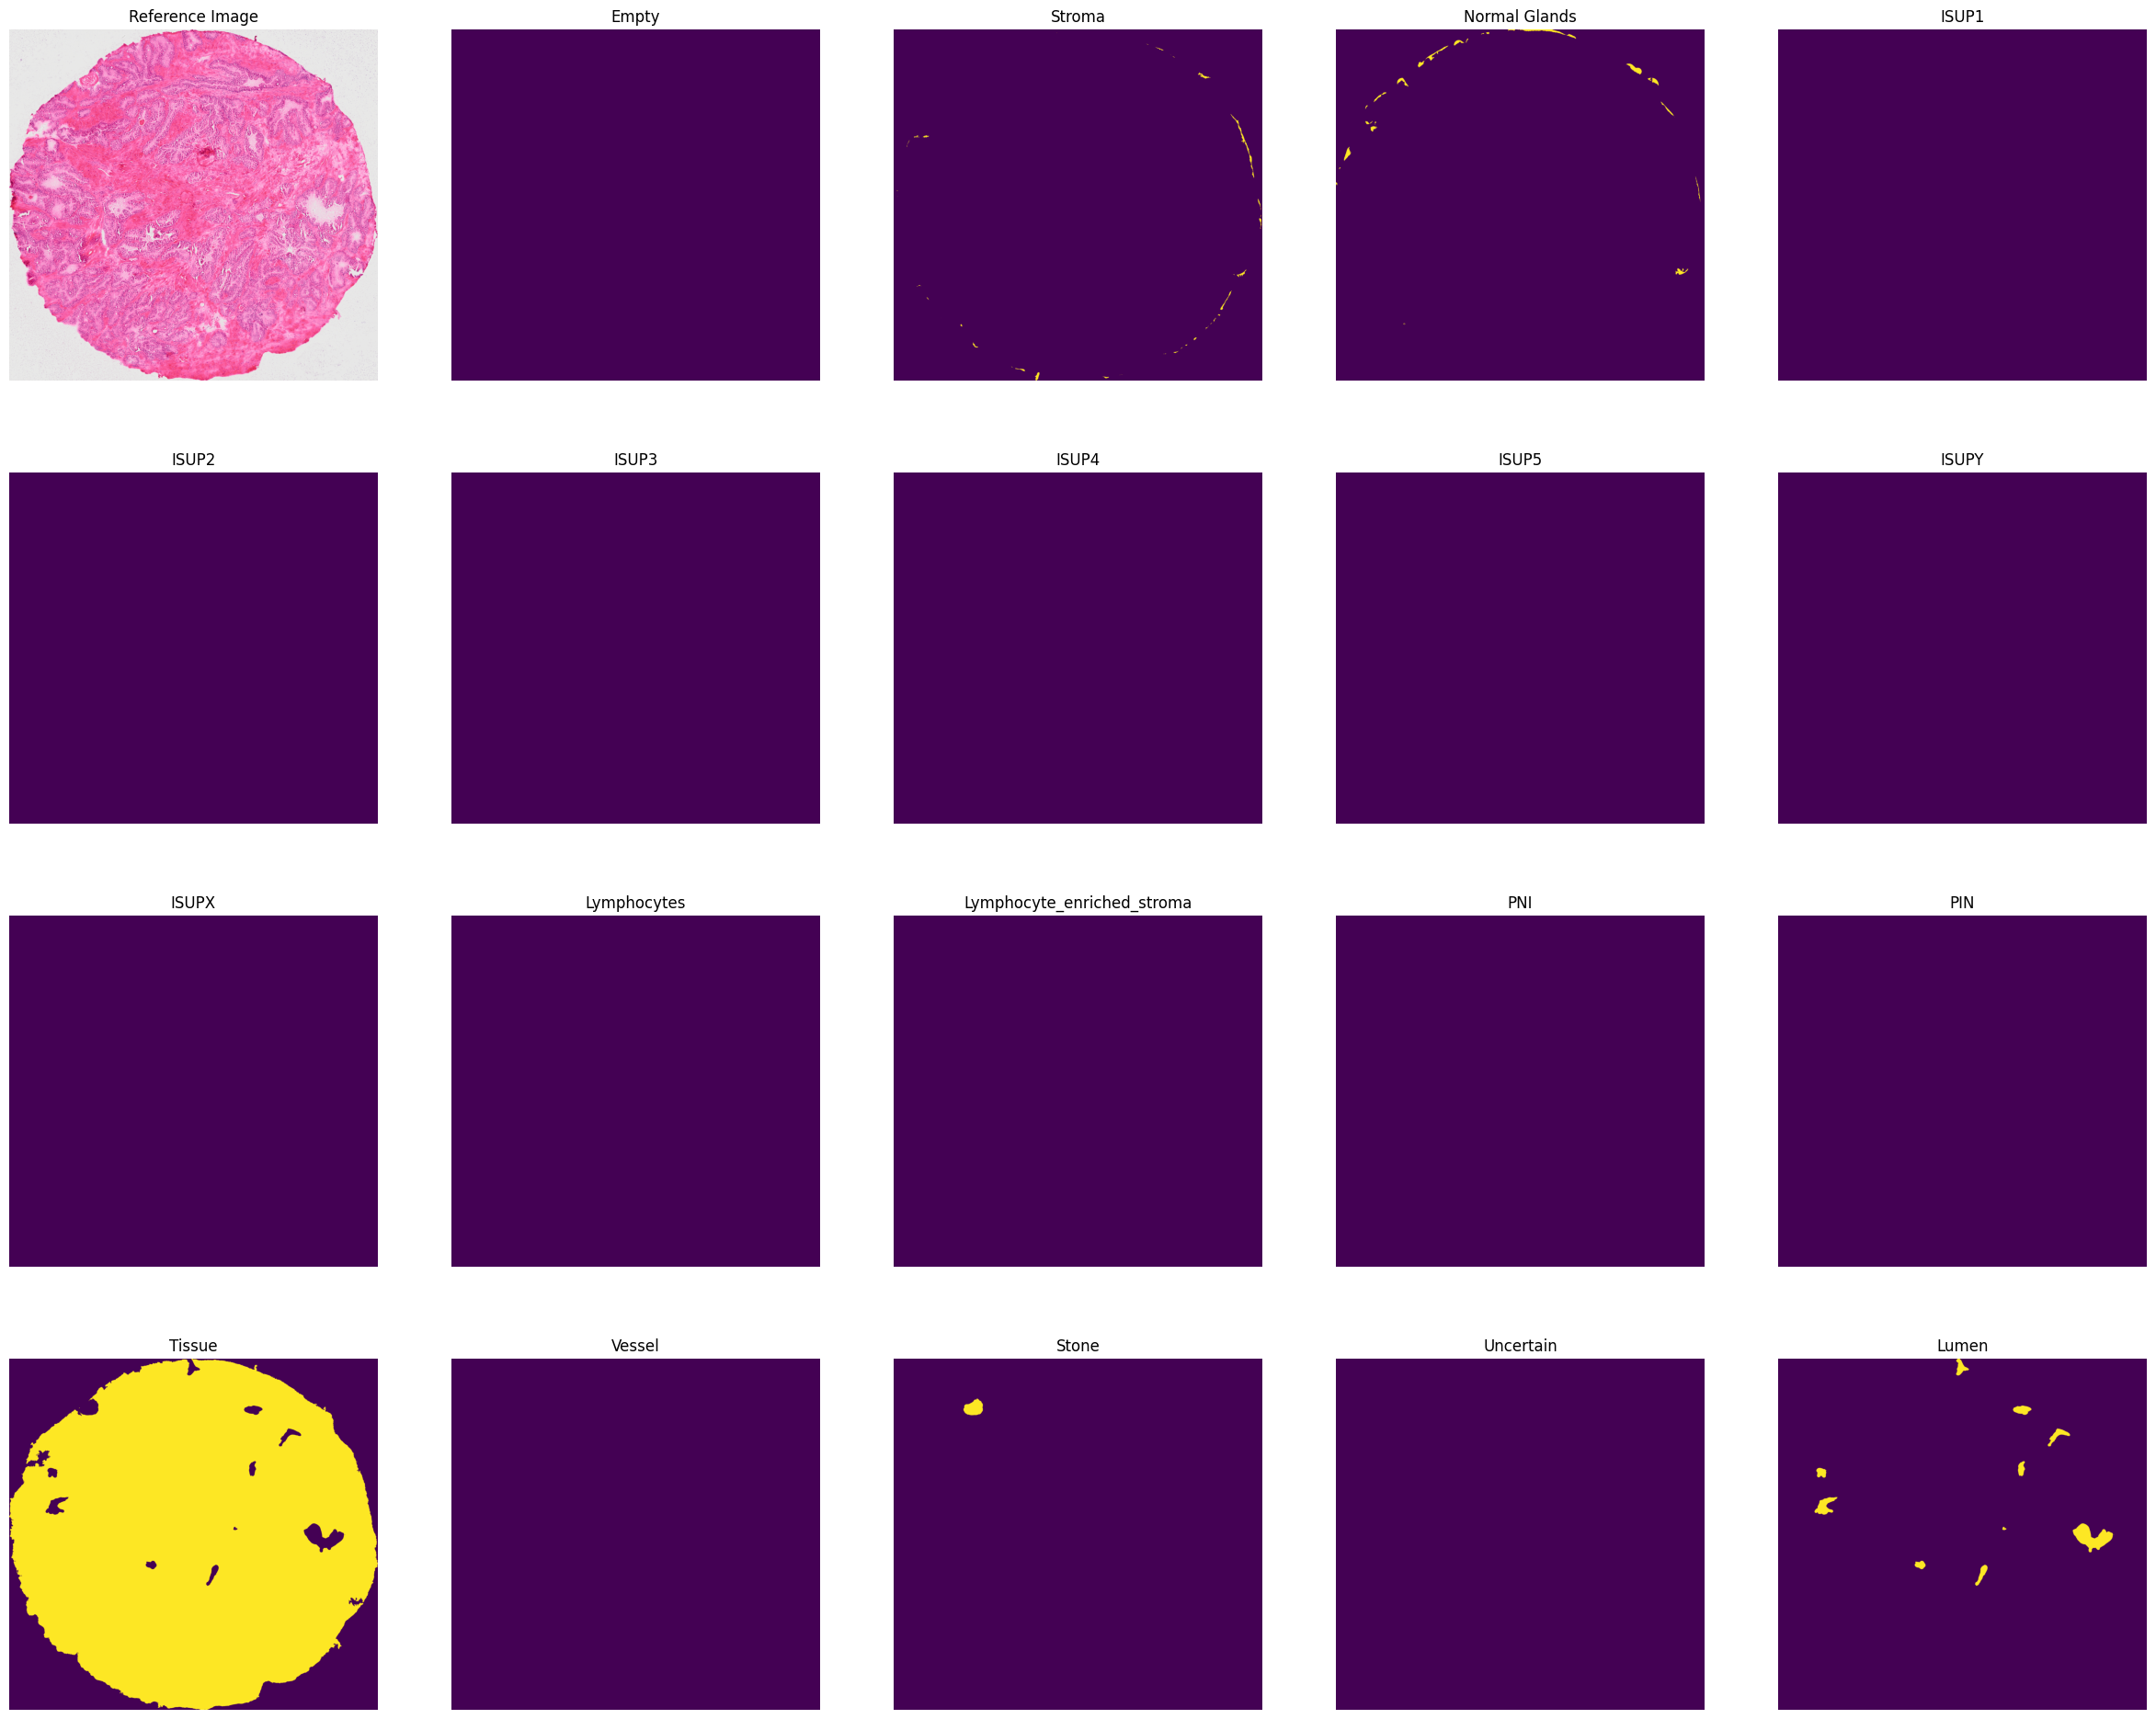

In [9]:
hist_annotations2.plot_annotation(reference_image=reference_image.data)

As we can see, annotations for Stroma and Normal Glands have mostly vanished. That is because they overlap with the "Tissue" annotation and by converting to multichannel mode, annotations that overlap will be overwritten. We can convert the data back to singlechannel mode.

In [10]:
hist_annotations2.convert_to_singlechannel()

assert not hist_annotations2.is_multichannel

### Pointsets

The `Pointset` class differs a little from the previous data types. Instead of image data, the `Pointset` class exists to deal with point valued data such as landmarks.

Internally, `Pointset` data is stored as pandas DataFrames. Using DataFrames allows to store metainformation for each coordinate. By default, `x` and `y` axis are indexed using the `x` and `y`. The `x_axis` and `y_axis` attributes can be set to override this section. When loading the data with `Pointset.load_from_path` some arguments for loading the pandas DataFrame can be passed.

In [11]:
# The last of the standard annotation types are Pointsets.
# We start off by loading the data with a library of our choice. Internally, pointsets are processed as pandas dataframes, so we load them as such as well.
df = pd.read_csv(join(ROOT_DIR, 'test_data/source_data/7/landmarks/07.csv'), index_col='label')

# After loading successfully we can initialize a Pointset object. By definition, pointsets use 'x' and 'y' column names to determine pixel locations.
# If the dataframe uses different column names, those can be set in `x_axis` and `y_axis` arguments.
landmarks = Pointset(data=df, name='landmarks', index_col=0)
landmarks.data.head(5)

x            y
label                         
Pt-0   739.560093  1725.627076
Pt-1   270.583625  1667.566174
Pt-2   405.458686  2006.206250
Pt-3   256.864171  2004.706193
Pt-4   231.123689  1750.924836

`Pointset`s also have a `to_numpy` method that can be used to extract the point data as a numpy array.

In [12]:
landmarks.to_numpy()

array([[ 739.56009334, 1725.62707611],
       [ 270.58362507, 1667.56617412],
       [ 405.45868638, 2006.20624967],
       [ 256.86417114, 2004.70619304],
       [ 231.12368924, 1750.92483639],
       [ 794.67857594, 1433.03318701],
       [1102.44791498, 1357.67615443],
       [1101.81743019, 1476.62375275],
       [ 698.55228712, 1544.88967413],
       [ 639.93733661, 1234.89185104],
       [ 406.49929897,  917.70101746],
       [ 196.14763828,  982.69588871],
       [ 419.03057715, 1565.57448234],
       [ 535.48222493,  944.90924673],
       [ 582.58335568,  686.99883132],
       [ 636.47407733,  709.95447256],
       [ 669.02200688,  656.25753551],
       [ 588.03591451,  610.03432873],
       [ 762.18287429,  479.8387041 ],
       [ 863.77040974,  460.199878  ],
       [ 741.84646128,  312.21735122],
       [1028.74499592,  198.86660528],
       [          inf,           inf],
       [1140.37236613,  125.79285854],
       [          inf,           inf],
       [1167.75689057,   

In [13]:
# Or, we use MIIT's utility loader function
landmarks2 = Pointset.load_from_path(join(ROOT_DIR, 'test_data/source_data/7/landmarks/07.csv'), index_col='label')

assert np.all(landmarks.data == landmarks2.data)

### GeoJSONData

Internally, geojson data is stored as a `geojson` object in the `data` attribute. `GeoJSONData` shares most functionality with other basetypes of MIIT. Since `GeoJSONData` itself cannot be used in the later stages of the spatial integration (see other notebooks), we have a utility function that converts `GeoJSONData` to `Annotation`, called `to_annotation`. Since we work mostly with QuPath data, this function is tailored towards QuPath at the moment. It takes as an optional argument a label function that extracts a label from each feature. If not given, the ID of the feature is used.

In [14]:
gdata = GeoJSONData.load_from_path(join(ROOT_DIR, 'test_data/source_data/2/annotations/annotations.geojson'))

In [15]:
def get_annotation_name(feature):
    properties = feature.get('properties', None)
    if properties is None or properties['objectType'] != 'annotation':
        return feature['id']
    classification = properties.get('classification', None)
    if classification is None:
        return feature['id']
    return classification.get('name', feature['id'])

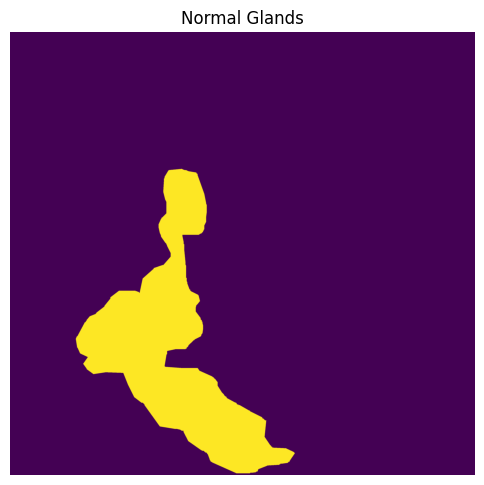

In [16]:
ann = geojson_to_annotation(gdata, reference_image.data, label_fun=get_annotation_name)
ann.plot_annotation()

### OMETIFFImage & OMETIFFAnnotation

This part is currently missing and will be added shortly. In principle, ometiff images and annotations can be loaded the same way as normal images, e.g., `OMETIFFImage.load_from_path()`

### OME & other large scale images

MIIT supports file formats, such as ome.tiff and ome.zarr, that are often used in biological image analysis throgh the class `OMEImage`. This class essentially provides a wrapper around `BioImage`, but adds additional information, such as resolution that are currently not implemented in the base class itself. 

`OMEImage` currently stores any image as ome.tiff. Support for ome.zarr might follow in the future.

In contrast to `Image` and `Annotation` classes, `OMEImage` can contain multiple images and multiple images. In `MIIT`, images are separates by pages and channels. Dimensions `Z` and `T` are not used at the moment. While multiple images with different resolutions are possible, MIIT assumes that each image has the same resolution. If resolutions from other images in the `OMEImage` differ from the resolution of the `main_page`, they are ignored. By default, `OMEImage` returns an image of shape `Y x X x [S]`. This can be configures using `dim_order`. 

While `BioImage` supports `xarray` and `dask`, `MIIT` uses only `numpy` at the moment.

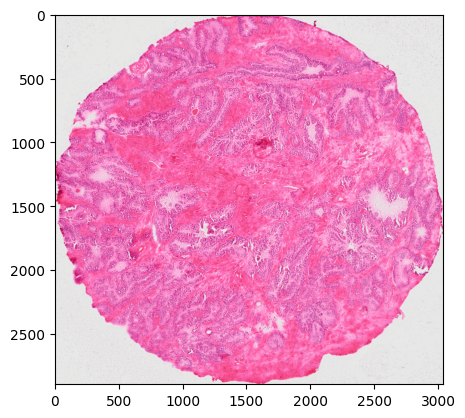

In [17]:
img = OMEImage.load_from_path(join(ROOT_DIR, 'test_data/source_data/7/images/image.tif'))

plt.imshow(img.data)

The default method for retrieving data from `OMEImage`, the `data` attribute can be used. This will return the image data for a `main_page` and `main_channel`. More flexibility is available with the default `BioImage` method `OMEImage.img.get_image_data()`.

A difference to `Image` and `Annotation` is that interpolation_modes can be set dynamically due to the flexible nature of `ome` data. 

By default, `LINEAR` interpolation is assumed for each `page` and `channels`. Using the method `set_interpolation_mode`, these can be updated with varying degrees of granularity.

In [18]:
print('Default interpolation modes: ', img.interpolation_mode)

# Update interpolation modes

img.set_interpolation_mode('NN')

print('Updated interpolation data:', img.interpolation_mode)

Default interpolation modes:  OrderedDict([('image.tif', OrderedDict([(np.str_('Channel:0:0'), 'LINEAR')]))])
Updated interpolation data: OrderedDict([('image.tif', OrderedDict([(np.str_('Channel:0:0'), 'NN')]))])


All `OMEImage` instances are stored as `ome.tiff` images. `OMEImage` aims to store as much metadata as possible in the `EXTRATAGS` of the `tif` image file. Any other data that might be more complex (e.g., nested dictionaries) as saved in an additional `additional_metadata.json` file.

In [19]:
img.store_as_ome_tiff_image(path='output_directory/ometiffexample.ome.tiff')

img_loaded = OMEImage.load_from_path('output_directory/ometiffexample.ome.tiff')

assert img._id == img_loaded._id

## Section

The `Section` class functions as a composite class that can be used to join several data types together. Every attribute in a `Section` class is assumed to occupy the same image space. The `Section` class provides several utility functions for transforming spatial data. 

The main attributes of the `Section` class are `reference_image` which is the image used for registration, `annotations` where base types are stored in and `so_data` where more complex spatial omics types are stored in.

`Section`s have other benefits when registering and warping image that we show in the next notebook.

In [20]:
# Now that we have the reference image and all additional datapoints, we can build sections.

section = Section(reference_image=reference_image,
                  annotations=[tissue_mask, hist_annotations, landmarks])

`Section` objects have a utility function for retrieving annotations of interest using the `get_annotations_by_names` method. This method will retrieve any object in the `annotations` attribute as long as the `name` attribute has been used. (An alternative is the `get_annotation_by_id` method which requires the ID.)

In [21]:
# To make it easier get find annotations again, we have a utility function to find the data in sections.
tissue_mask_from_section = section.get_annotation_by_name('tissue_mask')

Text(0.5, 1.0, 'Reference image + landmarks')

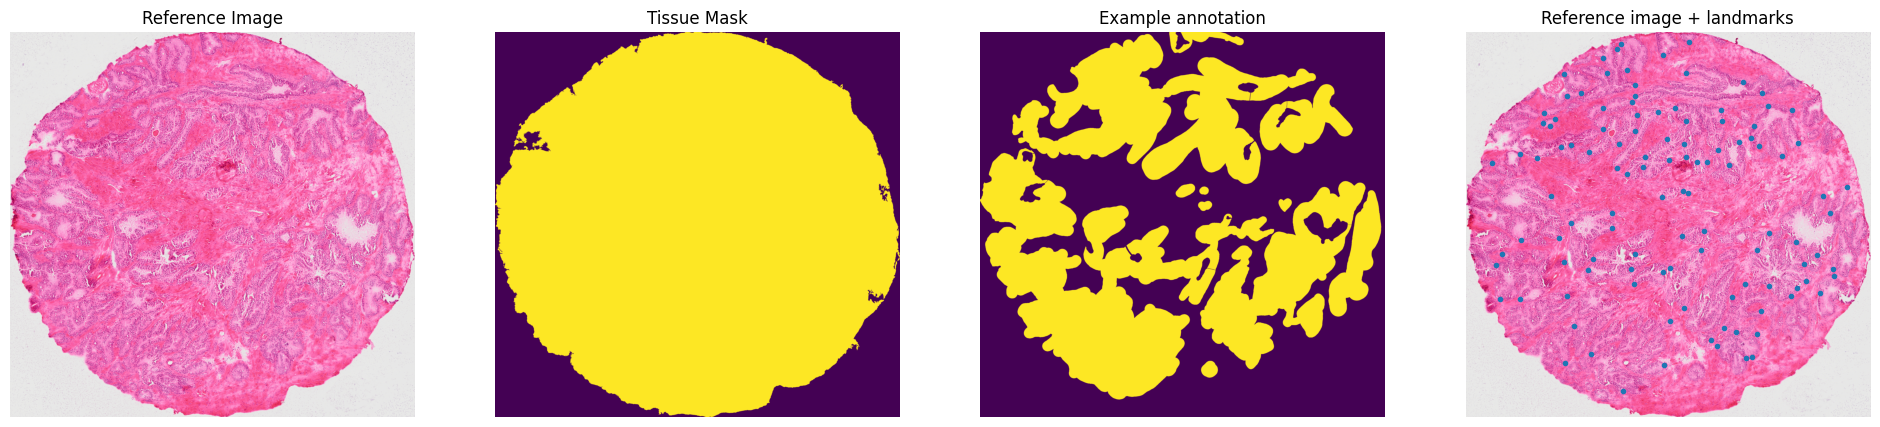

In [22]:
# We can illustrate the section.
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(section.reference_image.data)
axs[0].set_title('Reference Image')
axs[1].imshow(tissue_mask_from_section.data)
ann = section.get_annotation_by_name('hist_annotations')
axs[1].set_title('Tissue Mask')
axs[2].imshow(ann.data[:,:,2])
axs[2].set_title('Example annotation')
axs[3].imshow(section.reference_image.data)
ps = section.get_annotation_by_name('landmarks').to_numpy()
axs[3].plot(ps[:,0], ps[:,1], '.')
axs[3].set_title('Reference image + landmarks')

Section objects also have a small utility function that shows a summary of all attached data.

In [23]:
section.print_additional_data_summary()

########################################################################
# Name             # ID                                   # Type       #
########################################################################
# tissue_mask      # c1819bde-aa9b-11f0-a2f7-fa163e1aeabd # annotation #
# hist_annotations # c1afa9d4-aa9b-11f0-a2f7-fa163e1aeabd # annotation #
# landmarks        # e52c1460-aa9b-11f0-a2f7-fa163e1aeabd # pointset   #
########################################################################


## Spatial Omcis Data

In the next section we highlight the spatial omics datatypes. The distinction between `spatialomics` and `basetypes` can be a bit murky, but `spatialomics` consists of more complex datatypes that might contain several `basetypes`. 

### Loading Visium data

`Visium` data is used to work with Visium arrays by 10X Genomics. There are a few methods for constructing `Visium` objects, but the easiest to point to the output directory of spaceranger.

In [24]:
# Now we start with loading Visium data. We use the helper classmethod `from_spcrng` to load all the data automatically.
st_data = Visium.from_spcrng(directory=join(ROOT_DIR, 'test_data/source_data/2/spatial_transcriptomics/'))

Internally, each spot in the `Visium` is mapped to a reference image format which allows for accurate nonrigid registration. The important attributes for `Visium` data are the `ref_mat` and `table` attributes which map each spot to its spatial location. 

Text(0.5, 1.0, 'Reference Matrix')

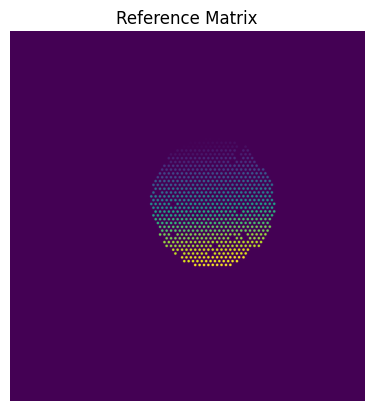

In [25]:
plt.imshow(st_data.ref_mat.data)
plt.axis('off')
plt.title('Reference Matrix')

In [26]:
st_data.table.data.head()

x            y  int_idx
0                                                   
TAGCGTGAATTGGCGT-1  583.554371  1010.814110        1
TACTCTGTAGCATCGG-1  583.554371  1034.482749        2
GGCTAGTCAGGTAGGA-1  583.554371  1058.151388        3
CGTTAATCGAATTGCT-1  583.554371  1081.820027        4
ATATCCTGTCTATCGT-1  583.554371  1129.565385        5

In [27]:
# We load data from the same section as the Visium slide. 
reference_image = Image.load_from_path(join(ROOT_DIR, 'test_data/source_data/2/images/image.tif'))
tissue_mask = Annotation.load_from_path(join(ROOT_DIR, 'test_data/source_data/2/masks/tissue_mask.tif'))
section = Section(reference_image=reference_image, annotations=[tissue_mask])

Text(0.5, 1.0, 'Visium Image')

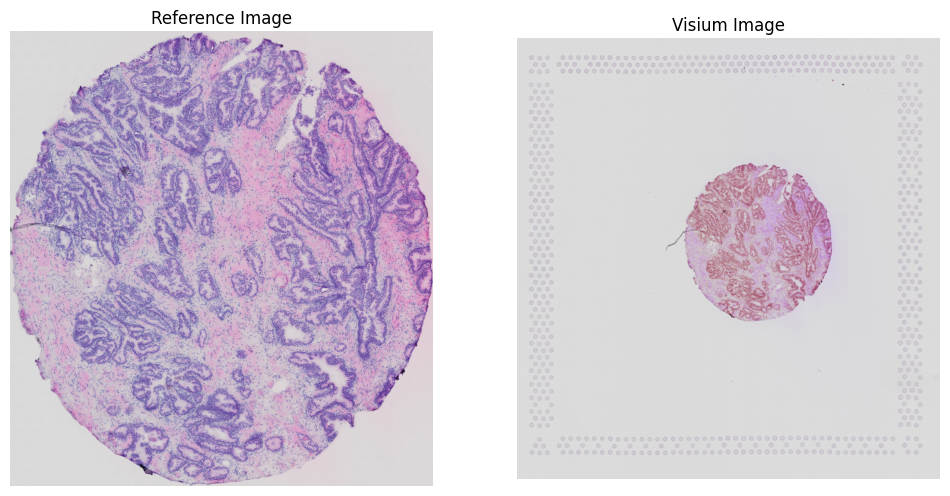

In [28]:
# We can compare both images now.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(section.reference_image.data)
axs[0].set_title('Reference Image')
axs[1].imshow(st_data.image.data)
axs[1].set_title('Visium Image')

We can see that the reference image of the `section` and the histology section used for ST data are different (i.e. one is the cropped form of the other). In order to add the ST data to the `section` class we need to transform the `Visium` data to the image space of the `section` object. MIIT has a utility function for this: `register_to_ref_image`. This function takes as input a target image, a source image and the data to be transformed. By default, `register_to_ref_image` uses the `OpenCVAffineRegisterer` registration algorithm for registration, but others can be supplied as well. The `OpenCVAffineRegister` implements an affine registration based on landmarks which works well for registration of the same image in different crop ratios as presented here.

In [29]:
# We see that both image are differently cropped. All imaging data in a section should be spatially aligned, so we use
# a utility function for registering both images.

# `register_to_ref_image` relies on the OpenCVAffine registerer, though other registerers can be added.
warped_st_data, _, registered_image = register_to_ref_image(section.reference_image.data, st_data.image.data, st_data)

Text(0.5, 1.0, 'Registered Visium Image')

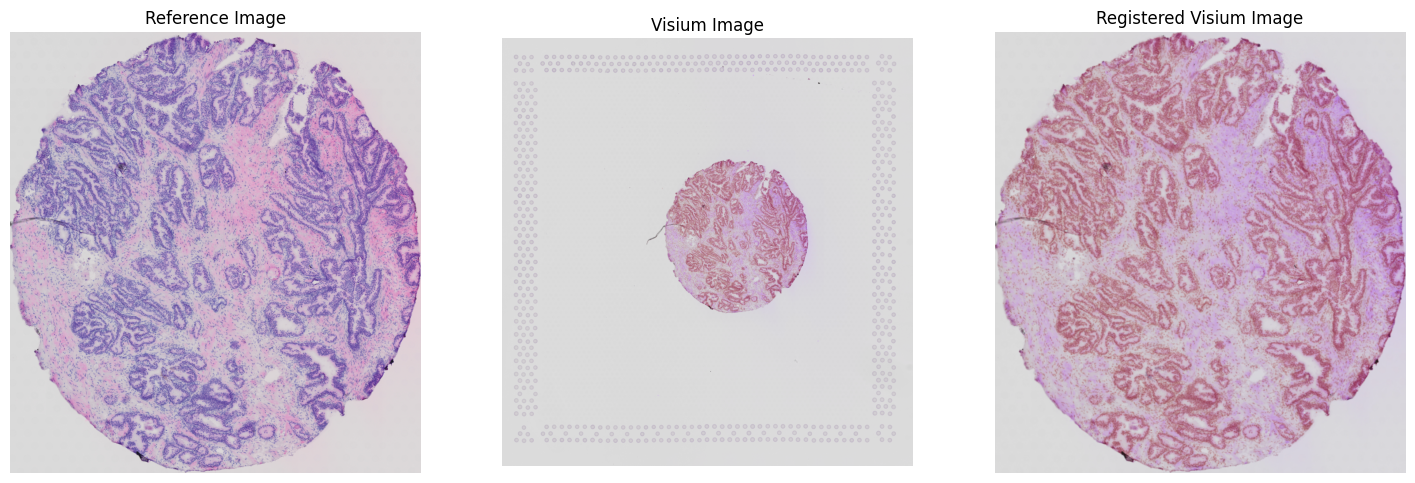

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(section.reference_image.data)
axs[0].set_title('Reference Image')
axs[1].imshow(st_data.image.data)
axs[1].set_title('Visium Image')
axs[2].imshow(registered_image.data)
axs[2].set_title('Registered Visium Image')

We see that after registration, both images occupy the same space and `Visium` data can be added to the section.

In [31]:
# Now that st data is registered, we can add it to sections.
section.so_data.append(warped_st_data)

In [32]:
# We also provide a summary function that lists all additional imaging data in a section.
section.print_additional_data_summary()

############################################################
# Name # ID                                   # Type       #
############################################################
#      # f25b281a-aa9b-11f0-a2f7-fa163e1aeabd # annotation #
#      # f59c8064-aa9b-11f0-a2f7-fa163e1aeabd # visium     #
############################################################


BaseImaging objects support a few basic image operation (see source code for now).

### Loading MSI data

In the next example we show how to load msi data. For now, we support the `imzML` format for hanlding msi data.


Note, at the moment the image resolution of MSI data should be passed along. That means, for instance, if the resolution of the imzML data is 30 um per pixel and the image resolution is supposed to be 1 um per pixel, then `target_resolution` should be set to 1. Important: The `target_resolution` parameter is unitless and will scale with whatever unit is specified in the imzML file.

In [33]:
# We start out by simply using a classmethod for initializing imzml data

imzml_path = join(ROOT_DIR, 'test_data/source_data/7/imzml/reduced_msi.imzML')
target_resolution = 1

imzml_neg_1 = Imzml.init_msi_data(imzml_path, target_resolution=target_resolution, name='negative ion mode')

/home/maximilw/scratch/maximilw/miniconda3/envs/gfh_integration/lib/python3.11/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


In [34]:
imzml_neg_1.spec_to_ref_map

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 33,
 33: 34,
 34: 35,
 35: 36,
 36: 37,
 37: 38,
 38: 39,
 39: 40,
 40: 41,
 41: 42,
 42: 43,
 43: 44,
 44: 45,
 45: 46,
 46: 47,
 47: 48,
 48: 49,
 49: 50,
 50: 51,
 51: 52,
 52: 53,
 53: 54,
 54: 55,
 55: 56,
 56: 57,
 57: 58,
 58: 59,
 59: 60,
 60: 61,
 61: 62,
 62: 63,
 63: 64,
 64: 65,
 65: 66,
 66: 67,
 67: 68,
 68: 69,
 69: 70,
 70: 71,
 71: 72,
 72: 73,
 73: 74,
 74: 75,
 75: 76,
 76: 77,
 77: 78,
 78: 79,
 79: 80,
 80: 81,
 81: 82,
 82: 83,
 83: 84,
 84: 85,
 85: 86,
 86: 87,
 87: 88,
 88: 89,
 89: 90,
 90: 91,
 91: 92,
 92: 93,
 93: 94,
 94: 95,
 95: 96,
 96: 97,
 97: 98,
 98: 99,
 99: 100,
 100: 101,
 101: 102,
 102: 103,
 103: 104,
 104: 105,
 105: 106,
 106: 107,
 107: 108,
 108: 109,
 109: 110,
 110: 11

Similarly to `Visium`, `Imzml` objects map from each pixel to a reference data format. The important attributes that contain this mapping are `ref_mat` and `spec_to_ref_map`.

Text(0.5, 1.0, 'MSI-Pixel distribution')

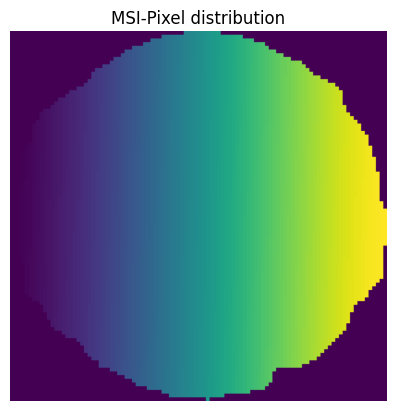

In [35]:
# The return of the conversion are a ref_mat, which is a matrix representation of the spatial distribution of 
# msi-pixels. spec_to_ref_map contains the mapping from each reference in `ref_mat` to its original msi-pixel.
# This mapping will be used internally in Imzml objects during integration.
plt.imshow(imzml_neg_1.ref_mat.data)
plt.axis('off')
plt.title('MSI-Pixel distribution')

In [36]:
imzml_neg_1.spec_to_ref_map

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 33,
 33: 34,
 34: 35,
 35: 36,
 36: 37,
 37: 38,
 38: 39,
 39: 40,
 40: 41,
 41: 42,
 42: 43,
 43: 44,
 44: 45,
 45: 46,
 46: 47,
 47: 48,
 48: 49,
 49: 50,
 50: 51,
 51: 52,
 52: 53,
 53: 54,
 54: 55,
 55: 56,
 56: 57,
 57: 58,
 58: 59,
 59: 60,
 60: 61,
 61: 62,
 62: 63,
 63: 64,
 64: 65,
 65: 66,
 66: 67,
 67: 68,
 68: 69,
 69: 70,
 70: 71,
 71: 72,
 72: 73,
 73: 74,
 74: 75,
 75: 76,
 76: 77,
 77: 78,
 78: 79,
 79: 80,
 80: 81,
 81: 82,
 82: 83,
 83: 84,
 84: 85,
 85: 86,
 86: 87,
 87: 88,
 88: 89,
 89: 90,
 90: 91,
 91: 92,
 92: 93,
 93: 94,
 94: 95,
 95: 96,
 96: 97,
 97: 98,
 98: 99,
 99: 100,
 100: 101,
 101: 102,
 102: 103,
 103: 104,
 104: 105,
 105: 106,
 106: 107,
 107: 108,
 108: 109,
 109: 110,
 110: 11

MSI data might differ from the associated histology image a bit and need to be correctly aligned for downstream analysis.

First, we need an image presentation of the MSI data. MIIT implements 3 different options for this:
1. PCA image: Here, the first principal component of all msi spectra is used to derive an image.
2. Ion images: We can extract ion images from the MSI file if we have ions that correlate well with the histology.
3. Masks: We can also use masks that are exported with MSI data (e.g. from SCiLS) and use those as an image presentation.

In [37]:
# Since we are working with a reduced dataset the spectrum is a bit smaller than usual.
imzml_neg_1.msi.getspectrum(0)[0]

array([174.8240924 , 191.01209831])

In [38]:
msi_hist_image_path = join(ROOT_DIR, 'test_data/source_data/7/images/image.tif')
msi_hist_image = Image.load_from_path(msi_hist_image_path)

Text(0.5, 1.0, 'Mask')

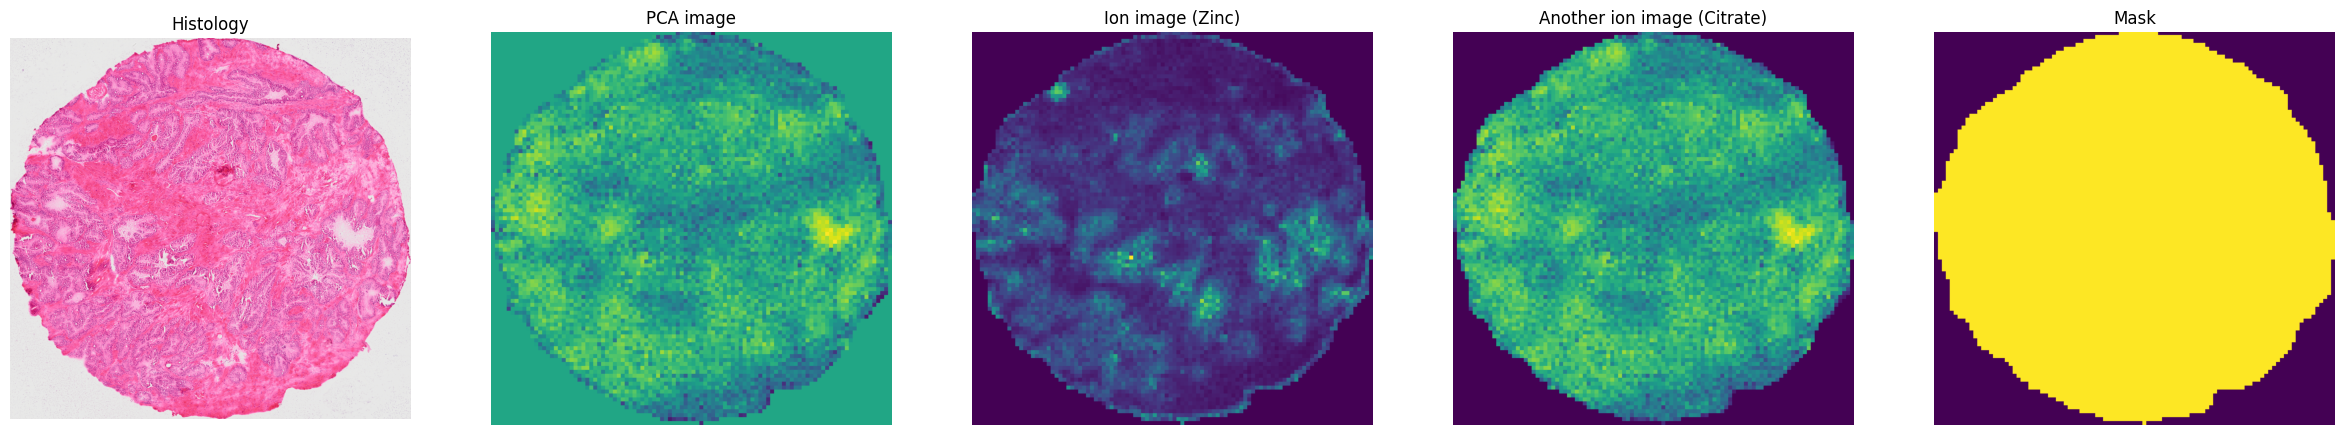

In [39]:
from miit.utils.scils import read_srd_with_msi

pca_img = imzml_neg_1.get_pca_img()

ion_image1 = imzml_neg_1.extract_ion_image_by_idx(0)
ion_image2 = imzml_neg_1.extract_ion_image(191.01209831)

mask = imzml_neg_1.ref_mat.data > imzml_neg_1.background

fig, axs = plt.subplots(1, 5, figsize=(6 * 5, 6 * 1))
for ax in axs:
    ax.axis('off')
axs[0].imshow(msi_hist_image.data)
axs[0].set_title('Histology')
axs[1].imshow(pca_img.data)
axs[1].set_title('PCA image')
axs[2].imshow(ion_image1.data)
axs[2].set_title('Ion image (Zinc)')
axs[3].imshow(ion_image2.data)
axs[3].set_title('Another ion image (Citrate)')
axs[4].imshow(mask)
axs[4].set_title('Mask')


Choosing the right image presentation is highly dependent of the use case. This time, we will use the PCA image.

Now that we have an image presentation, we can look at the registration. For the MSI registration to histology image, we have a custom registerer, which we named `MSItoHistMetaRegisterer`. Its called meta registerer, because this registration algorithm performs the preprocessing specifically for histology image - msi registration, but still needs a registration algorithm for the actual registration. By default, `MSItoHistMetaRegisterer` uses the `NiftyReg` registration algorihm in `rigid` mode.

(Note, that currently we only support the `rigid` registration mode for `NiftyReg`. Other modes will follow shortly.)

Text(0.5, 1.0, 'PCA image after registration')

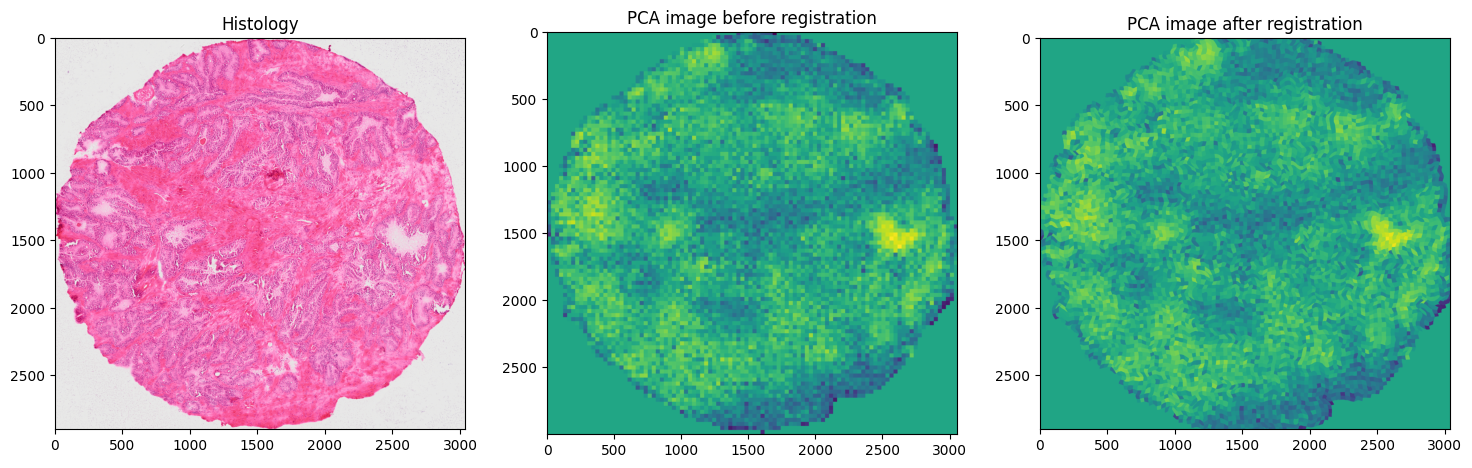

In [40]:
# Now, msi data might be offset a little bit from the histology image.For this case, we have a separate registration algorithm.
# By default, we use NiftyReg as a registration algorithm, though others can be supplied as well.
# For the registration, we derive an image presentation based on the PCA spectrum.
# We supply the ref_mat, so that the data can be transformed directly in the function.
from miit.registerers.other.msi_to_hist_meta_registerer import MSItoHistMetaRegisterer



registerer = MSItoHistMetaRegisterer()

warped_imzml_neg, transformation, warped_image = register_to_ref_image(msi_hist_image.data, 
                                                       pca_img.data, 
                                                       imzml_neg_1,
                                                       registerer=registerer)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(msi_hist_image.data)
axs[0].set_title('Histology')
axs[1].imshow(pca_img.data)
axs[1].set_title('PCA image before registration')
axs[2].imshow(warped_image.data)
axs[2].set_title('PCA image after registration')

Since this is a very cropped image the registration doesnt look like it made a big impact, though this differs on other images.

In [41]:
section2 = Section()
section2.reference_image = msi_hist_image
section2.so_data.append(imzml_neg_1)

section2.print_additional_data_summary()

####################################################################
# Name              # ID                                   # Type  #
####################################################################
# negative ion mode # f8412ed2-aa9b-11f0-a2f7-fa163e1aeabd # Imzml #
####################################################################


### Storing and loading sections

MIIT has support for loading and storing imaging data types. At the moment, data is stored in a semi human readable format. A more compacter one-file solution will follow soon.

In [42]:
section.store('output_directory/tmp_store')

The output should look something that. This format is somewhat human readable. In `attributes.json` the mapping of each imaging type to `uuid` is documented.

```
.
├── 1855e684-9140-11ef-b86d-fa163eee643f
│   ├── attributes.json
│   └── image.nii.gz
├── 39127ee6-9140-11ef-b86d-fa163eee643f
│   ├── attributes.json
│   ├── config.json
│   ├── image
│   │   ├── attributes.json
│   │   └── image.nii.gz
│   ├── ref_mat
│   │   ├── additional_attributes.json
│   │   ├── annotations.nii.gz
│   │   └── labels.json
│   ├── scale_factors.json
│   ├── spec_to_ref_mat.json
│   └── table
│       ├── attributes.json
│       └── pointset.csv
├── attributes.json
└── meta_information.json
```

In [43]:
# Similarly, the data can be loaded using the load function.

loaded_section = Section.load('output_directory/tmp_store/')

### Adding new data types.

MIIT has support for adding new data types. For basic imaging types, we can add new data types by implementing either the `BaseImaging` or `BasePointset` interfaces. For
spatial omics datatypes that are more complex, the `BaseSpatialOmics` interface can be implemented.

If storing and loading of new datatypes should be supported, the new dataypes can be added to the `SpatialDataLoader` class. (example to follow soon.)